## PROJECT: Analyze A/B Test Results
### BY: TINIKA DARDEN

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#check)
- [Submission](#submission)


<a id='intro'></a>
### [Introduction](#intro)

For this project, I will be displaying the results of an A/B test run by an e-commerce website.  The ultimate goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### [Part I - Probability](#probability)

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [5]:
# Read in the `ab_data.csv` data and create a dataframe.
ab = pd.read_csv('ab_data.csv')
ab.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [8]:
# Display the number of rows and columns in the dataset table.
ab.shape

(294478, 5)

In [9]:
# Display the number of unique users in the dataset.
ab.user_id.nunique()

290584

In [10]:
# Display the proportion of users converted.
ab['converted'].mean()

0.11965919355605512

In [11]:
# Display count "group" is treatment but "landing_page" isnt a new_page
Treat_Old = ab.query('group == "treatment" and landing_page != "new_page"').count()[0]
NoTreat_New = ab.query('group != "treatment" and landing_page == "new_page"').count()[0]
Treat_Old + NoTreat_New     

3893

Do any of the rows have missing values?

In [13]:
# Check for missing values in rows
ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**The dataset has no null values and that is displayed by calling for the info of the dataframe.**

The rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. 

In [14]:
# Remove inaccurate rows
ab_2 = ab[((ab.group == 'treatment') & (ab.landing_page == 'new_page')) | ((ab.group == 'control') & (ab.landing_page == 'old_page'))]

In [15]:
# Display new shape of clean dataset
ab_2.shape

(290585, 5)

In [18]:
# Display count of unique **user_id**s in new dataset
ab_2.user_id.nunique()

290584

In [19]:
# Remove duplicate **user_id**
ab_2 = ab_2.drop_duplicates()

In [20]:
# Check if there are anymore duplicates left in dataset
sum(ab_2.duplicated())

0

What is the probability of an individual converting regardless of the page they receive?

In [21]:
#create a probability for a population that converts overall.
P_pop = ab_2['converted'].mean()
P_pop

0.11959667567149027

For the population in the control group, what is the probability they converted?

In [22]:
# Create control population dataframe
control = ab_2.query('group == "control"')
P_control = control['converted'].mean()
P_control

0.1203863045004612

For the population in the treatment group, what is the probability they converted?

In [23]:
# Create treatment population dataframe
treat = ab_2.query('group == "treatment"')
P_treat = treat['converted'].mean()
P_treat

0.11880724790277405

Display the difference (obs_diff) between the conversion rates for the two groups.

In [24]:
# Create a difference dataframe to compare the two groups
obs_diff = P_treat - P_control
obs_diff

-0.0015790565976871451

What is the probability that an individual enjoyed the new page?

In [26]:
ab_2.query('landing_page == "new_page"').count()[0] / ab_2.shape[0]

0.5000636646764286

 For the data given are we able to determine whether the new treatment group users lead to more conversions?

They are odds are about the same for the new page as it isfor the old page. The probability for an individual who received the new page is 50%, so I would assume that the old page was going to be the same. The conversion rate for the control group and the treatment group only have a difference of -0.001.

<a id='ab_test'></a>
### [Part II - A/B Test](#ab_test)

Lets run a hypothesis test continuously as each observation was observed.

**H0: P_old >= P_new - The null hypothesis is that the conversion rate from the old page is greater than or equal to the new page.**

**H1: P_old < P_new - The alternative hypothesis is the conversion rate from the old page is less than the new page.**

In [27]:
# Display **convert rate** for $p_{new}$ under the null
P_new = ab_2.converted.mean()
P_new

0.11959667567149027

In [28]:
# Display **convert rate** for $p_{old}$ under the null
P_old = ab_2.converted.mean()
P_old

0.11959667567149027

In [29]:
#Display a null hypothesis with a new page $n_{new}$
n_new = ab_2.query('landing_page == "new_page"').count()[0]
n_new

145311

In [30]:
# Display the null hypothesis with an old page $n_{old}$
n_old = ab_2.query('landing_page =="old_page"').count()[0]
n_old

145274

Simulate  nnew  transactions with a conversion rate of  pnew  under the null hypothesis.

In [31]:
# Simulate a Sample for the treatment Group
np_converted = np.random.choice([0,1], size = n_new, p = [1 - P_new, P_new]).mean()

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null. 

In [32]:
# Simulate a Sample for the control Group
op_converted = np.random.choice([0,1], size = n_old, p = [1 - P_old, P_old]).mean()

Find the difference in the "converted" probability  (p_new  -  p_old)  for simulated samples from the treatment and control groups.

In [33]:
#Create a probability dataframe to compare the two groups
P_diff = np_converted.mean() - op_converted.mean()
P_diff

0.0013050415051850672

Find the  (p_new  -  p_old)  value 10,000 times using the same simulation process.

In [34]:
# Sampling distribution 
p_diffs = []
for _ in range(10000):
    np_converted = np.random.binomial(n_new, P_new, 10000)/n_new
    op_converted = np.random.binomial(n_old, P_old, 10000)/n_old
    p_diffs = np_converted - op_converted

Plot a histogram of the **p_diffs**.

(array([   5.,   25.,  252., 1056., 2427., 3133., 2156.,  771.,  153.,
          22.]),
 array([-0.00524071, -0.00426751, -0.00329431, -0.00232111, -0.00134791,
        -0.00037471,  0.00059849,  0.00157169,  0.00254489,  0.00351809,
         0.00449129]),
 <BarContainer object of 10 artists>)

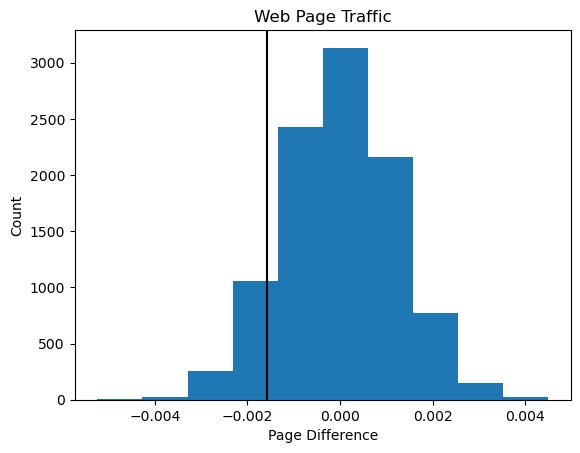

In [35]:
plt.title('Web Page Traffic')
plt.xlabel('Page Difference')
plt.ylabel('Count')
plt.axvline(x= obs_diff, color='black')
plt.hist(p_diffs)

What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [36]:
# Show average proportion for the probability and the actual differences.
(p_diffs > obs_diff).mean()

0.9034

What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The P-Value is the probability of obtaining the observed statistic. The P-Value of 90% implies that the null hypothesis is True. The null hypothesis fails to be rejected (with a type I error rate of 5% this P-Value greatly exceeds that) and it makes more sense to keep the old page instead of replacing it with a new one.**

In [38]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = ab_2.query('landing_page =="old_page"').converted.sum()

# number of conversions with the new_page
convert_new = ab_2.query('landing_page == "new_page"').converted.sum()

# number of individuals who were shown the old_page
n_old = ab_2.query('landing_page == "old_page"').count()[0]

# number of individuals who received new_page
n_new = ab_2.query('landing_page == "new_page"').count()[0]

In [40]:
import statsmodels.api as sm
# Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], value = None, alternative = 'smaller', prop_var = False)
print(z_score, p_value)

1.3116075339133115 0.905173705140591


What do the z-score and p-value mean for the conversion rates of the old and new pages? 

**The z-score is measured by standard deviations from the mean used to calculate p-value and reach a conclusion to our hypothesis.

The p-value has a 90% probability to get an observed difference due to the null hypothesis being True. The test results provides evidence that shows the new page doesn't convert more users than the old page. It would be a better choice to keep the original website..**

<a id='regression'></a>
### [Part III - A regression approach](#regression)

Since each row in the ab_2 data is either a conversion or no conversion, a logistic regression would be performed.

Is there a significant difference in conversion based on which page a customer receives?  

In [42]:
# Create column for intercept
# Create  dummy variable column for which page each user received
ab_2['intercept'] = 1
ab_2['ab_page'] = pd.get_dummies(ab_2['group'])['treatment']
ab_2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [43]:
# Instantiate regression model
import statsmodels.api as sm

lm = sm.Logit(ab_2['converted'], ab_2[['intercept', 'ab_page']])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [44]:
# Summary of regression model
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.6032
Date:               2022-11-05 19:40 BIC:              212801.7625
No. Observations:   290585           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290583           LLR p-value:      0.18965    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3116  0.1897  -0.0374   0.0074
==================================================================

"""

##### The p-value associated with ab_page is 0.19. This p-value differs because the null and alternative hypthesis models assumed there's an equal probability of the old and new page converting users Both of the p-values were more than 5% for the Type 1 error rate.

Part II uses a one-tailed test because the null hypothesis states the convert_new >= convert_old.

Part III used a two-tailed test because the null hypothesis is convert_old = convert_new

P-value is > alpha(0.05), so we must reject to fail the null hypothesis.**

##### Other factors that might influence whether or not an individual converts could be their age group. By creating a controlled age group variable for users would benefit research. Due to different age groups having various interests, that would influence the results of the test.

The possible disadvantages of having multiple factors in a model is that it can return a few high R-square values. This isn't good because it's indicative of errors and under and over-predicts the data. This would make a huge impact on our results.

##### Lets see if there was an effect based on which country a user lives. We'll  read in the **countries.csv** dataset and merge them together.  

Does it appear that country had an impact on conversion? 

In [48]:
# Read the countries data.
countries = pd.read_csv('./countries.csv')

In [47]:
# Display countries table
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [49]:
# Join both datasets by shared column.
ab_countries = countries.set_index('user_id').join(ab_2.set_index('user_id'), how='inner')

In [50]:
# Display the newly joined tables
ab_countries.head(10)

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1
630005,US,2017-01-17 21:22:25.940766,treatment,new_page,1,1,1
630006,US,2017-01-14 05:13:51.962356,treatment,new_page,0,1,1
630008,US,2017-01-11 16:11:11.131461,control,old_page,0,1,0
630009,US,2017-01-05 23:35:15.820565,control,old_page,1,1,0


In [53]:
# Create dummy variables fpr each country in dataset.
countries[['CA', 'UK', 'US']] = pd.get_dummies(countries['country'])

# drop the country column since this is not necessary
countries = countries.drop('country', 1)
countries.head(10)

C:\Users\tdard\AppData\Local\Temp\ipykernel_14012\1360149960.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  countries = countries.drop('country', 1)


,user_id,CA,UK,US
0,834778,0,1,0
1,928468,0,0,1
2,822059,0,1,0
3,711597,0,1,0
4,710616,0,1,0
5,909908,0,1,0
6,811617,0,0,1
7,938122,0,0,1
8,887018,0,0,1
9,820683,0,0,1


In [55]:
# Join the ab_countries table with the new dummy dataset.
ab_countries = countries.set_index('user_id').join(ab_2.set_index('user_id'), how = 'inner')
ab_countries.head(10)

,CA,UK,US,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,,,
630000,0,0,1,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1
630001,0,0,1,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1
630002,0,0,1,2017-01-19 19:20:56.438330,control,old_page,0,1,0
630003,0,0,1,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1
630004,0,0,1,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1
630005,0,0,1,2017-01-17 21:22:25.940766,treatment,new_page,1,1,1
630006,0,0,1,2017-01-14 05:13:51.962356,treatment,new_page,0,1,1
630008,0,0,1,2017-01-11 16:11:11.131461,control,old_page,0,1,0
630009,0,0,1,2017-01-05 23:35:15.820565,control,old_page,1,1,0


In [56]:
# Add columns to make countries neater
ab_countries['US_ab'] = ab_countries['US'] * ab_countries['ab_page']
ab_countries['CA_ab'] = ab_countries['CA'] * ab_countries['ab_page']
ab_countries['UK_ab'] = ab_countries['UK'] * ab_countries['ab_page']

In [57]:
# Fit model, and summarize the results
lm2 = sm.Logit(ab_countries['converted'], ab_countries[['intercept', 'US_ab', 'UK_ab', 'CA_ab']])
results = lm2.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366108
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212779.1904
Date:               2022-11-05 20:06 BIC:              212821.5090
No. Observations:   290585           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.067776   
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
US_ab        -0.0183    0.0126    -1.4495  0.1472  -0.0430   0.0064
UK_ab         0.0074    0.0180     0.4098  0.6819  -0.0279   0.0427
CA_ab        -0.0827    0.0380    -2.1763  0.0295  -0.1571  -0.0082
==================================================================

"""

In [59]:
# Display data parameters
np.exp(results.params)

intercept    0.136863
US_ab        0.981890
UK_ab        1.007417
CA_ab        0.920649
dtype: float64

<a id='conclusions'></a>
## [Conclusions](#conclusions)

**Using the information given in the dataset, the Z-test, logistic regression, and differences observed, the test results have proven that the new vs the old page have an equal chance(50/50) of converting users.**

Between the 3 countries given in our dataset we can see that the UK was impacted by 1.00 and the US has an impact of 0.98 and CA had an impact of 0.92. The results have have a small difference and doesn't prove to make a major impact on the example coWe fail to reject the null hypothesis. I recommend that the company should keep the old page instead of using their "new site. Another possible optionis to create another study with a different site for a controlled time and additional factors like age could give a possibly bigger difference than the current replacement option. This will save the company time and money if they stick with the original site.